

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

  


## The Effect of The Curse of Dimensionality on K-Nearest Neighbors

#### Mason Farnsworth
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Lei Liu, Graduate Student, The University of Texas at Austin


### Executive Summary

The Curse of Dimensionality is a set of challenges found when working with high dimensional datasets. We will explore the effects that it has on k-nearest neighbors using datasets ranging from 2-6 features. These features will be used to predict "Production". The mean squared error (MSE) for those predictions is our visualization for the effect of the Curse of Dimensionality. We will see the MSE increase (this means our model is not predicted as well) as we increase the amount of features used. This increase could be due to a few different effects from the Curse of Dimensionality. The first effect is the sparsity of data points in feature space as the dimensions increase. This sparsity makes it harder to find neighbors with similar characteristics. The sparsity also results in data points being equidistant, making it difficult for the algorithm to discern any meaningful patterns. Lastly, overfitting may occur resulting in noise or outliers making more of an impact on the model.

### Import Packages

In [1]:
import math                                                 # basic calculations like square root
from sklearn.neighbors import KNeighborsRegressor           # for nearest k neighbours                              
from sklearn.model_selection import cross_val_score         # cross validation methods
import pandas as pd                                         # DataFrames and plotting
import numpy as np                                          # arrays and matrix math
import matplotlib.pyplot as plt                             # plotting
import warnings
warnings.filterwarnings('ignore')                           # supress warnings

C:\Users\Mason\Documents\Personal\Python\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Load Data

The following workflow applies the .csv file 'unconv_MV_v5.csv', a datatset provided in the Subsurface Machine Learning course.

We will work with the following features:

* **porosity** - fraction of rock void in units of percentage
* **permeability** - ability of a fluid to flow through the rock in mil;iDarcy
* **acoustic impedence** - product of sonic velocity and rock density in unitsof $kg/m^2s*10^3$
* **brittleness** - the tendency for rocks to bypass deformation and become subject to catastrophic failure
* **total organic carbon** - the total amount of organic carbon present
* **vitrinite reflectance** - used to study the maturity of hydrocarbons in the rock
* **production** - the amount of hydrocarbons produced

The following code block is modified from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).

In [2]:
my_data = pd.read_csv("unconv_MV_v5.csv")  
np.random.seed(seed = 13)                                 # set the random number seed
noise_stdev = 500                                         
'''
The purpose of creating noise here is so we can more clearly observe 
any impacts from the Curse of Dimensionality due to noise and overfitting.
'''
my_data['Prod'] = my_data['Prod'] + np.random.normal(loc=0.0,scale=noise_stdev,size = len(my_data))

### Creating an MSE distribution using k nearest neighbors

In this workflow the goal is to end up with a single scatterplot showing different MSE curves for varying amounts of dimensions when using k-nearest nieghbors.

1. Clear out any negative values
2. Standardize data
3. Create MSE models for dimensions of 2-6 features
4. Plotting the MSE distribution

### 1. Clear out any negative values

First we will check for any negative values in our dataset. We do this because in each of our features it would be physically impossible to end up with a negative value. 

After we encounter any negative values, we will set each of them to zero to maintain those data as being as low as possible. That way they re still physically possible and we can continue using them in the dataset.

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).

In [3]:
my_data = my_data.iloc[:,1:8]                               # copy all rows and columns 1 through 8, note 0 column is removed
my_data.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.07000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.03500,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.95500,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.51000,58.262500,84.330000
TOC,200.0,0.990450,0.481588,-0.190000,0.617500,1.03000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.96000,2.142500,2.870000
Prod,200.0,4289.442798,1050.801635,1971.849921,3584.756335,4271.54616,4963.181397,7094.030832


TOC has a a minimum less than 0, which is physically impossible, so we will clear that up and set anything less than 0 to 0

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).

In [4]:
num = my_data._get_numeric_data()                           # get the numerical values
num[num < 0] = 0                                            # truncate negative values to 0.0
my_data.describe().transpose()  

,count,mean,std,min,25%,50%,75%,max
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.07000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.03500,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.95500,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.51000,58.262500,84.330000
TOC,200.0,0.991950,0.478264,0.000000,0.617500,1.03000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.96000,2.142500,2.870000
Prod,200.0,4289.442798,1050.801635,1971.849921,3584.756335,4271.54616,4963.181397,7094.030832


### 2. Standardize the data

The reason for standardizing this data is due to the feature space, where some features may be much larger than others numerically speaking. This could push our feature space into 1 dimension. Instead, we standardize the data to have a mean of 0 and a variance of 1.

The following code block is modified from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).

In [5]:
from sklearn.preprocessing import StandardScaler

transform = StandardScaler(); 

features = ['Por','Brittle', 'Perm', 'TOC', 'AI', 'VR']

my_data['sPor'] = transform.fit_transform(my_data.loc[:,features].values)[:,0] 
my_data['sBrittle'] = transform.fit_transform(my_data.loc[:,features].values)[:,1] 
my_data['sPerm'] = transform.fit_transform(my_data.loc[:,features].values)[:,2]
my_data['sTOC'] = transform.fit_transform(my_data.loc[:,features].values)[:,3]
my_data['sAI'] = transform.fit_transform(my_data.loc[:,features].values)[:,4]
my_data['sVR'] = transform.fit_transform(my_data.loc[:,features].values)[:,5]
my_data.head()

,Por,Perm,AI,Brittle,TOC,VR,Prod,sPor,sBrittle,sPerm,sTOC,sAI,sVR
0,12.08,2.92,2.80,81.40,1.16,2.31,3809.000860,-0.982256,2.358297,-0.817030,0.352257,-0.298603,1.152048
1,12.38,3.53,3.22,46.17,0.89,1.88,3938.029394,-0.881032,-0.141332,-0.463751,-0.213702,0.444147,-0.280931
2,14.02,2.59,4.01,72.80,0.89,2.72,4262.097035,-0.327677,1.748113,-1.008148,-0.213702,1.841224,2.518377
3,17.67,6.75,2.63,39.81,1.08,1.88,5324.587038,0.903875,-0.592585,1.401098,0.184565,-0.599240,-0.280931
4,17.52,4.57,3.18,10.94,1.51,1.90,4078.683686,0.853263,-2.640962,0.138561,1.085907,0.373409,-0.214280


Here you see our new standardized data, where the names are made by simply adding "s" in front of the original feature names. You'll notice that the standardized versions are comparatively closer to each other, numerically, than the originial feature values.

### 3. Creating MSE curves for dimensions of 2-6 features

Here we are using a k-fold cross validation on each of our feature spaces to give us a more accurate MSE distribution. In this code our "KNeighborsRegressor()" function from sklearn is a vital component for implementing k-nearest neighbors. 

The following code block is modified from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).

In [6]:
score2 = []                                                  # code modified from StackOverFlow by Dimosthenis
k_mat2 = []
for k in range(1,150):
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 1)
    scores2 = cross_val_score(estimator=neigh_dist, X= np.c_[my_data['sPor'],my_data['sBrittle']],y=my_data['Prod'], cv=4, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
    score2.append(abs(scores2.mean()))
    k_mat2.append(k)

score3 = []                                                  # code modified from StackOverFlow by Dimosthenis
k_mat3 = []
for k in range(1,150):
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 1)
    scores3 = cross_val_score(estimator=neigh_dist, X= np.c_[my_data['sPor'],my_data['sBrittle'],my_data['sPerm']],y=my_data['Prod'], cv=4, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
    score3.append(abs(scores3.mean()))
    k_mat3.append(k)
    
score4 = []                                                  # code modified from StackOverFlow by Dimosthenis
k_mat4 = []
for k in range(1,150):
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 1)
    scores4 = cross_val_score(estimator=neigh_dist, X= np.c_[my_data['sPor'],my_data['sBrittle'],my_data['sPerm'],my_data['sTOC']],y=my_data['Prod'], cv=4, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
    score4.append(abs(scores4.mean()))
    k_mat4.append(k)
    
score5 = []                                                  # code modified from StackOverFlow by Dimosthenis
k_mat5 = []
for k in range(1,150):
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 1)
    scores5 = cross_val_score(estimator=neigh_dist, X= np.c_[my_data['sPor'],my_data['sBrittle'],my_data['sPerm'],my_data['sTOC'],my_data['sAI']],y=my_data['Prod'], cv=4, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
    score5.append(abs(scores5.mean()))
    k_mat5.append(k)

score6 = []                                                  # code modified from StackOverFlow by Dimosthenis
k_mat6 = []
for k in range(1,150):
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 1)
    scores6 = cross_val_score(estimator=neigh_dist, X= np.c_[my_data['sPor'],my_data['sBrittle'],my_data['sPerm'],my_data['sTOC'],my_data['sAI'],my_data['sVR']],y=my_data['Prod'], cv=4, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
    score6.append(abs(scores6.mean()))
    k_mat6.append(k)

### 4. Plotting the MSE distribution

This graph shows the different MSE curves plotted against each other using the "kmat" lists we created in the third step. 

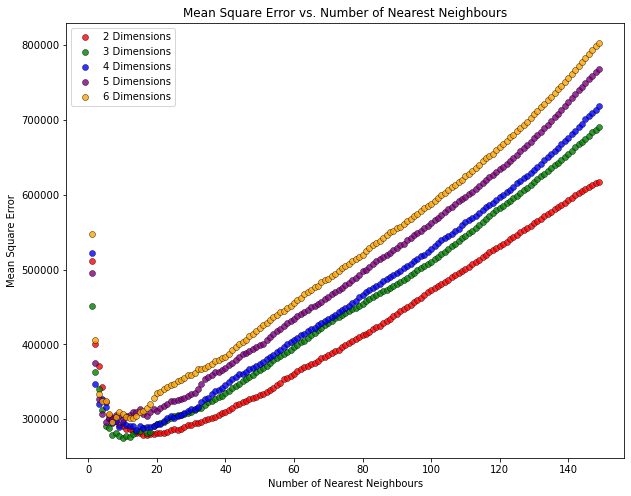

In [7]:
# Combine data for all dimensions
k_all = [k_mat2, k_mat3, k_mat4, k_mat5, k_mat6]
score_all = [score2, score3, score4, score5, score6]

# Corresponding colors for each dimension
colors = ['red', 'green', 'blue', 'purple', 'orange']

plt.figure(figsize=(10, 8))

# Plot all dimensions on the same graph
for i in range(len(k_all)):
    plt.scatter(k_all[i], score_all[i], s=None, c=colors[i], marker=None,
                alpha=0.8, linewidths=0.5, edgecolors="black",
                label=f'{i + 2} Dimensions')

plt.title('Mean Square Error vs. Number of Nearest Neighbours')
plt.xlabel('Number of Nearest Neighbours')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

### Results

Here we can more clearly see that dimensions 4-6 have a worse MSE curve and are clearly being affected by the Curse of Dimensionality. However, while 3 dimensions becomes much less optimal with increasing k neighbors, it does shows the lowest MSE at around 15 neighbors. In comparison, 2 dimensions reaches a similar MSE, but only after about 20 neighbors. 


I hope this was helpful,

Mason Farnsworth

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
